# Using Prophet to Forecast the Market

In a previous post, I used stock market data to show how prophet detects changepoints in a signal (http://pythondata.com/forecasting-time-series-data-prophet-trend-changepoints/). After publishing that article, I've received a few questions asking how well (or poorly) prophet can forecast the stock market.  

This article highlights using prophet for forecasting the markets.  


In [18]:
#!conda install -c conda-forge fbprophet -y
#!pip install --upgrade plotly
!pip3 install --upgrade pandas

     |████████████████████████████████| 9.5 MB 18.0 MB/s eta 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.0
    Uninstalling pandas-1.1.0:
      Successfully uninstalled pandas-1.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, which is not installed.
fbprophet 0.7.1 requires setuptools-git>=1.2, which is not installed.
mlx 1.0.16 requires pandas==1.1, but you have pandas 1.1.5 which is incompatible.
ads-lite 2.1.0 requires pandas==1.1, but you have pandas 1.1.5 which is incompatible.


In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
#import prohpet

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

%matplotlib inline
 
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

# Load data

Let's load our data to analyze. For this example, I'm going to use some stock market data to be able to show some clear trend changes. This data can be downloaded from FRED (https://fred.stlouisfed.org/series/SP500) or just grab it from the examples directory.  Note: The data used in this example was not cherry picked...I just grabbed the available data on S&P 500 from FRED.

In [48]:
market_df = pd.read_csv('/home/datascience/SP500.csv', index_col='DATE', parse_dates=True)

In [49]:
market_df.tail()

,SP500
DATE,
2021-09-29,4359.46
2021-09-30,4307.54
2021-10-01,4357.04
2021-10-04,4300.46
2021-10-05,4345.72


<AxesSubplot:xlabel='DATE'>

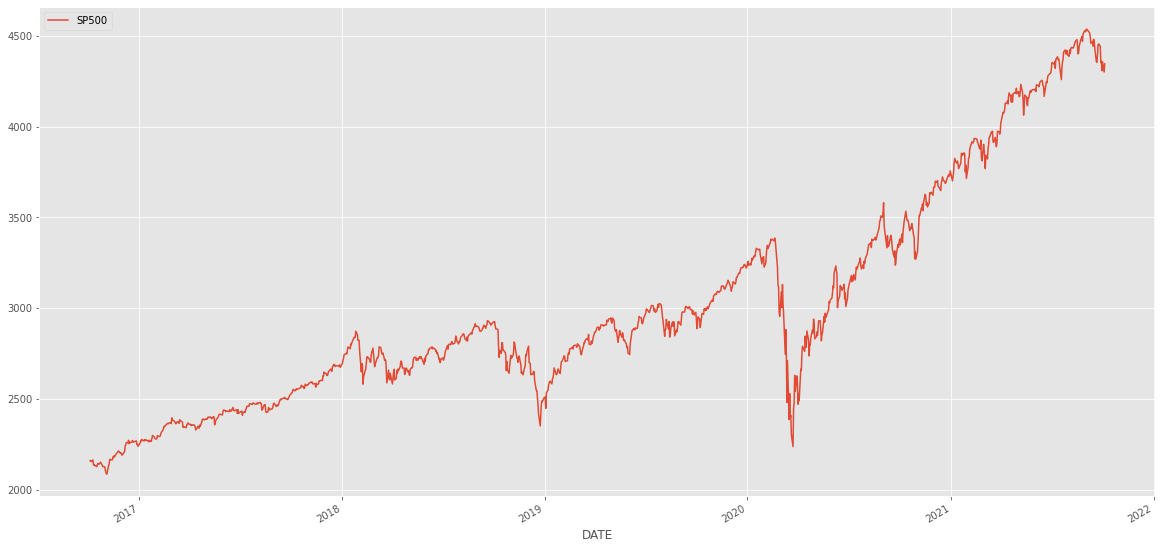

In [50]:
market_df = market_df[market_df['SP500'] != "."]
market_df = market_df.astype(float)
market_df.plot()

In [51]:
df = market_df.reset_index().rename(columns={'DATE':'ds', 'SP500':'y'})
df['y'] = np.log(df['y'])

# Running Prophet

As before, let's instantiate prophet and fit our data (including our future dataframe). Take a look at http://pythondata.com/forecasting-time-series-data-prophet-jupyter-notebook/ for more information on the basics of Prophet.

In [52]:
model = Prophet()
model.fit(df);
future = model.make_future_dataframe(periods=365) #forecasting for 1 year from now.
forecast = model.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


# Plotting the forecast

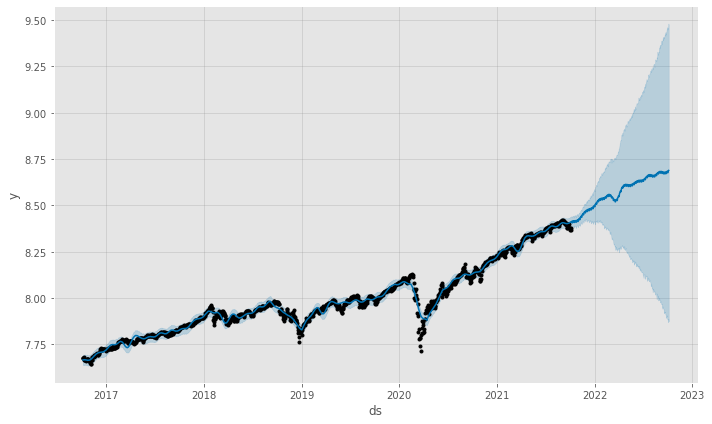

In [53]:
figure=model.plot(forecast)

With the data that we have, it is hard to see how good/bad the forecast (blue line) is compared to the actual data (black dots).  Let's take a look at the last 800 data points (~2 years) of forecast vs actual without looking at the future forecast (because we are just interested in getting a visual of the error between actual vs forecast).

In [54]:
two_years = forecast.set_index('ds').join(market_df)
two_years = two_years[['SP500', 'yhat', 'yhat_upper', 'yhat_lower' ]].dropna().tail(800)
two_years['yhat']=np.exp(two_years.yhat)
two_years['yhat_upper']=np.exp(two_years.yhat_upper)
two_years['yhat_lower']=np.exp(two_years.yhat_lower)

In [55]:
two_years.tail()

,SP500,yhat,yhat_upper,yhat_lower
ds,,,,
2021-09-29,4359.46,4478.259967,4606.027879,4358.215171
2021-09-30,4307.54,4480.376468,4607.873978,4359.001536
2021-10-01,4357.04,4486.057711,4616.245403,4357.478505
2021-10-04,4300.46,4494.182551,4623.048173,4373.450536
2021-10-05,4345.72,4502.116635,4627.575719,4376.641215


<AxesSubplot:xlabel='ds'>

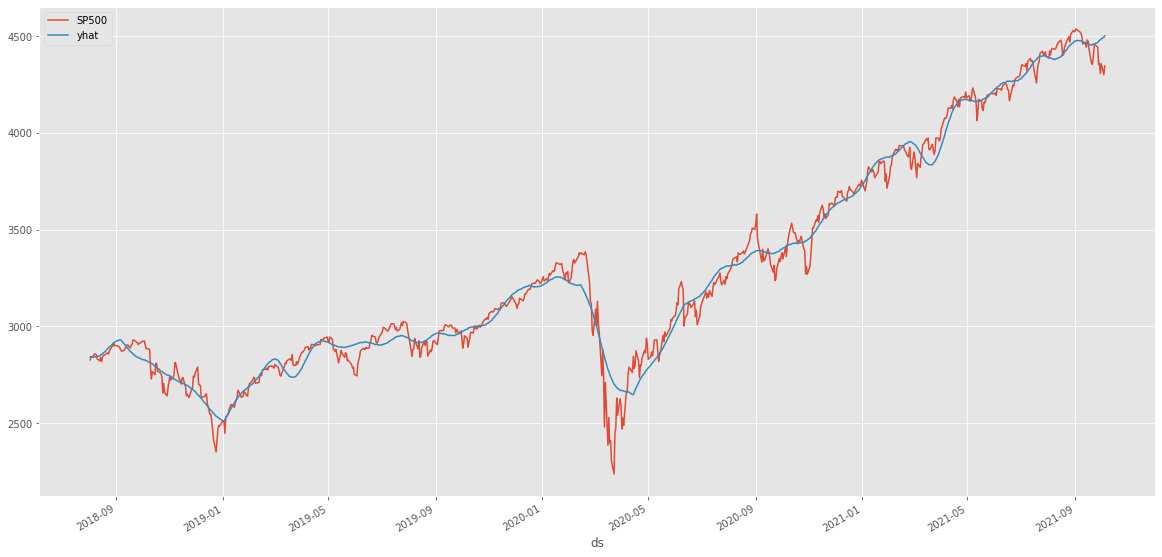

In [56]:
two_years[['SP500', 'yhat']].plot()

You can see from the above chart, our forecast follows the trend quite well but doesn't seem to that great at catching the 'volatility' of the market. Don't fret though...this may be a very good thing though for us if we are interested in 'riding the trend' rather than trying to catch peaks and dips perfectly.

Let's take a look at a few measures of accuracy.  First, the old fashioned 'average error'.

In [57]:
two_years_AE = (two_years.yhat - two_years.SP500)
print(two_years_AE.describe())


count    800.000000
mean      -1.433093
std       72.383778
min     -216.674969
25%      -44.793701
50%       -6.290713
75%       31.693675
max      464.059562
dtype: float64


Those really aren't bad numbers but they don't really tell all of the story. Let's take a look at a few more measures of accuracy.  

First, let's look at R-squared:

In [58]:
r2_score(two_years.SP500, two_years.yhat)  

0.983571917593576

R-squared looks really good...I'll take a 0.9 value in any first-go-round modeling approach.

Now, let's look at mean squared error:

In [59]:
mean_squared_error(two_years.SP500, two_years.yhat)

5234.915871020549

And there we have it...the real pointer to this modeling technique being a bit wonky.  

An MSE of 2260.28 for a model that is trying to predict the S&P500 with values between 1900 and 2500 isn't that good  (remember...for MSE, closer to zero is better) if you are trying to predict exact changes and movements up/down.

Now, let's look at the mean absolute error (MAE). The MAE is the measurement of absolute error  between two continuous variables and can give us a much better look at error rates than the standard mean.

In [60]:
mean_absolute_error(two_years.SP500, two_years.yhat)

51.00074715375996

The MAE is continuing to tell us that the forecast by prophet isn't ideal to use this forecast in trading. 

Another way to look at the usefulness of this forecast is to plot the upper and lower confidence bands of the forecast against the actuals. You can do that by plotting yhat_upper and yhat_lower.  

Text(0.5, 0, 'Date')

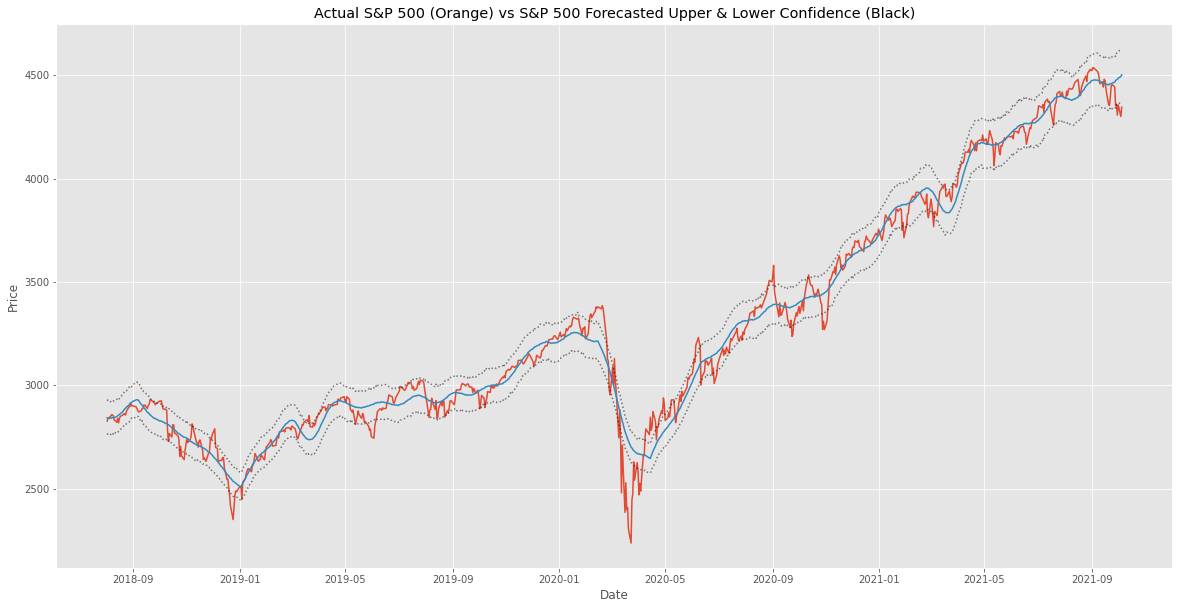

In [61]:
fig, ax1 = plt.subplots()
ax1.plot(two_years.SP500)
ax1.plot(two_years.yhat)
ax1.plot(two_years.yhat_upper, color='black',  linestyle=':', alpha=0.5)
ax1.plot(two_years.yhat_lower, color='black',  linestyle=':', alpha=0.5)

ax1.set_title('Actual S&P 500 (Orange) vs S&P 500 Forecasted Upper & Lower Confidence (Black)')
ax1.set_ylabel('Price')
ax1.set_xlabel('Date')


In the above chart, we can see the forecast (in blue) vs the actuals (in orange) with the upper and lower confidence bands in gray.  

You can't really tell anything quantifiable from this chart, but you can make a judgement on the value of the forecast. If you are trying to trade short-term (1 day to a few weeks) this forecast is almost useless but if you are investing with a timeframe of months to years, this forecast might provide some value to better understand the trend of the market and the forecasted trend.

Let's go back and look at the actual forecast to see if it might tell us anything different than the forecast vs the actual data.

In [62]:
full_df = forecast.set_index('ds').join(market_df)
full_df['yhat']=np.exp(full_df['yhat'])

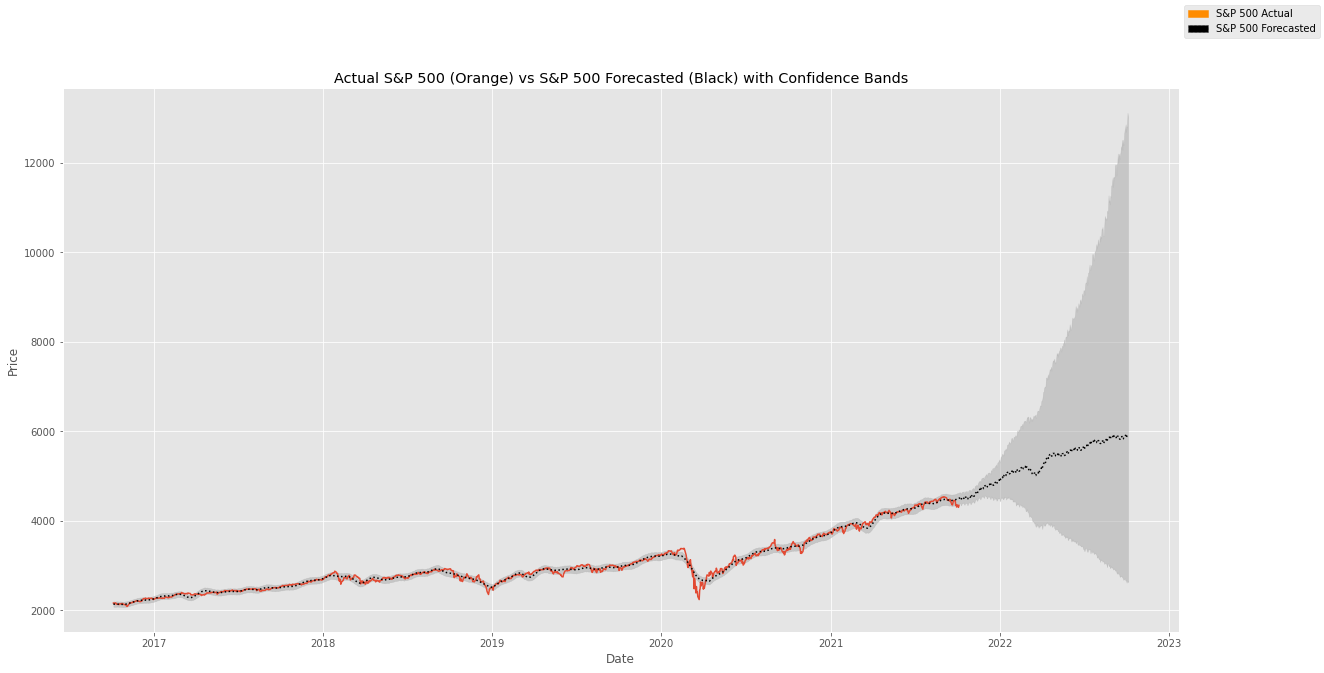

In [95]:
fig, ax1 = plt.subplots()
ax1.plot(full_df.SP500)
ax1.plot(full_df.yhat, color='black', linestyle=':')
ax1.fill_between(full_df.index, np.exp(full_df['yhat_upper']), np.exp(full_df['yhat_lower']), alpha=0.5, color='darkgray')
ax1.set_title('Actual S&P 500 (Orange) vs S&P 500 Forecasted (Black) with Confidence Bands')
ax1.set_ylabel('Price')
ax1.set_xlabel('Date')

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

orange_patch = mpatches.Patch(color='darkorange', label='S&P 500 Actual')
black_patch = mpatches.Patch(color='black', label='S&P 500 Forecasted', linestyle=":")
fig.legend(handles=[orange_patch, black_patch], loc='upper right')

This chart is a bit easier to understand vs the default prophet chart (in my opinion at least). We can see throughout the history of the actuals vs forecast, that prophet does an OK job forecasting but has trouble with the areas when the market become very volatile.

Looking specifically at the future forecast, prophet is telling us that the market is going to continue rising and should be around 2750 at the end of the forecast period, with confidence bands stretching from 2000-ish to 4000-ish.  

If you show this forecast to any serious trader / investor, they'd quickly shrug it off as a terrible forecast. Anything that has a 2000 point confidence interval is worthless in the short- and long-term investing world.

That said, is there *some* value in prophet's forecasting for the markets?  Maybe. 

Maybe we can use the forecast on weekly or monthly data with better accuracy. Or...maybe we can use the forecast combined with other forecasts to make a better forecast.  I may dig into that a bit more at some point in the future. Stay tuned.